In [1]:
import networkx as nx
import pandas as pd
import re
from tqdm.auto import tqdm

In [2]:
data = pd.read_csv("Tweets with topic labels.csv")

# 1. Exploratory Data Analysis

In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20493 entries, 0 to 20492
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Topic names  20493 non-null  object
 1   Topic index  20493 non-null  int64 
 2   username     20493 non-null  object
dtypes: int64(1), object(2)
memory usage: 480.4+ KB


In [4]:
data.head()

,Topic names,Topic index,username
0,Legal,15,ChatGPT_Thinks
1,Culinary,17,cordydbarb
2,Medical/Healthcare,11,puppetsucks
3,Social Media,1,0xPromptcraft
4,Chatbots & Generative AI,7,BadrBellaj


In [5]:
from collections import Counter

In [6]:
topic_counts = Counter(data["Topic names"])

In [7]:
topic_counts

Counter({'Legal': 670,
         'Culinary': 615,
         'Medical/Healthcare': 1043,
         'Social Media': 2546,
         'Chatbots & Generative AI': 1724,
         'Math': 703,
         'Natural Language Processing (NLP)': 2306,
         'Education': 2040,
         'Workforce': 967,
         'Prompt Engineering': 708,
         'Artificial Intelligence (AI)': 769,
         'Poetry': 666,
         'Search Engines': 1519,
         'Politics': 405,
         'Content Creation': 442,
         'Programming/Coding': 994,
         'Business & Marketing': 566,
         'Subscription Services': 724,
         'Music': 1086})

# 2. Creating Bipartite Graph between Users & Topics

In [8]:
B = nx.Graph()

# Add nodes from the "username" column with the 'bipartite' attribute set to 0
B.add_nodes_from(data["username"], bipartite=0)

# Add nodes from the "topic names" column with the 'bipartite' attribute set to 1
B.add_nodes_from(data["Topic names"], bipartite=1)

# Add edges between usernames and corresponding topics
for _, row in data.iterrows():
    username = row["username"]
    topic = row["Topic names"]
    B.add_edges_from([(username, topic)])

In [9]:
# Separate nodes by their bipartite attribute for visualization
user_nodes = [node for node, attr in B.nodes(data=True) if attr.get("bipartite") == 0]
topic_nodes = [node for node, attr in B.nodes(data=True) if attr.get("bipartite") == 1]

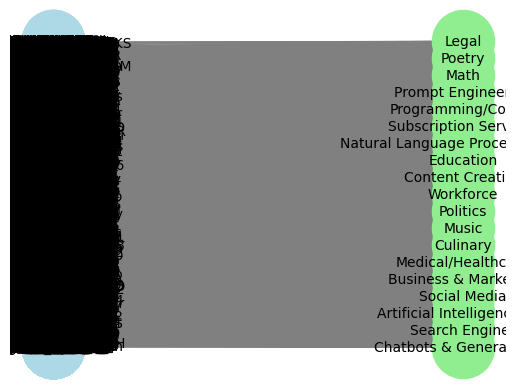

In [15]:
pos = nx.bipartite_layout(B, user_nodes)
nx.draw_networkx_nodes(B, pos, nodelist=user_nodes, node_color='lightblue', node_size=2000)
nx.draw_networkx_nodes(B, pos, nodelist=topic_nodes, node_color='lightgreen', node_size=2000)
nx.draw_networkx_edges(B, pos, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(B, pos, font_color='black', font_size=10)

plt.axis('off')
plt.show()

# 3. Creating Network Graph Between Users

Network graph between users is created from bipartite graph with edge weights representing the number of shared topics between users.

In [10]:
# Create a projection of the bipartite graph onto the users nodes
G = nx.bipartite.projected_graph(B, data['username'])

# Calculate the weight of edges based on the number of shared topics
for u, v, d in G.edges(data=True):
    shared_topics = len(set(B[u]).intersection(B[v]))
    d['weight'] = shared_topics

Check which user has the highest degree

In [11]:
degrees = dict(G.degree())

# Find the node with the highest degree
node_with_max_degree = max(degrees, key=degrees.get)

# Print the node and its degree
print("Node with the highest degree:", node_with_max_degree)
print("Degree:", degrees[node_with_max_degree])

Node with the highest degree: richardkimphd
Degree: 12532


Check which user has the lowest degree

In [12]:
degrees = dict(G.degree())

# Find the node with the lowest degree
node_with_max_degree = min(degrees, key=degrees.get)

# Print the node and its degree
print("Node with the lowest degree:", node_with_max_degree)
print("Degree:", degrees[node_with_max_degree])

Node with the lowest degree: block_chang
Degree: 378


## 3.1 Creating Ego Network of User "ArtIntPoetry"

Ego network of user "ArtIntPoetry" is created manually to remove the edges between neighbours themselves as otherwise the network will not be visible with too many edges.

In [38]:
neighbors = list(G.neighbors("ArtIntPoetry"))
g_ego = nx.Graph()
for x in neighbors:
    g_ego.add_edge("ArtIntPoetry",x)

Topics that user "ArtIntPoetry" is interested in

In [37]:
list(B.neighbors("ArtIntPoetry"))

['Search Engines', 'Poetry', 'Artificial Intelligence (AI)']

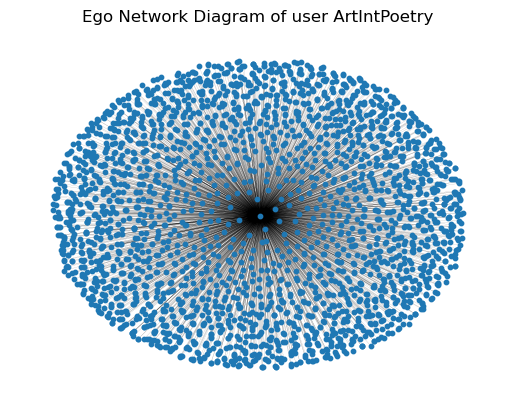

In [59]:
import matplotlib.pyplot as plt
egonet = nx.ego_graph(g_ego, 'ArtIntPoetry')
plt.plot()
nx.draw(egonet, node_size=10, width=0.05)
plt.title('Ego Network Diagram of user ArtIntPoetry')
plt.show()

# 4. Recommend Friends

In [119]:
def recommend_friends(B, G, user, j_threshold, topic_threshold):
    recommended_friends = []
    
    # Get the neighbors of the user in the bipartite graph (topics)
    user_topics = set(B.neighbors(user))
    
    # Iterate over the users in the network graph
    for other_user in G.neighbors(user):
        # Get the neighbors of the other user in the bipartite graph (topics)
        other_user_topics = set(B.neighbors(other_user))
        
        # Calculate the Jaccard similarity coefficient
        jaccard_similarity = len(user_topics.intersection(other_user_topics)) / len(user_topics.union(other_user_topics))
        num_shared_topics = len(user_topics.intersection(other_user_topics))
        
        if jaccard_similarity >= j_threshold and num_shared_topics >= topic_threshold:
            # Add the friend recommendation if Jaccard similarity exceeds the threshold
            recommended_friends.append((user, other_user, jaccard_similarity, num_shared_topics))
    
    return recommended_friends

recommended = recommend_friends(B, G, "ArtIntPoetry",j_threshold=0.5,topic_threshold=2)
print("Recommended Friends:")
print(recommended)

In [120]:
recommended = recommend_friends(B, G, "ArtIntPoetry",j_threshold=0.5,topic_threshold=2)
print("Recommended Friends:")
print(recommended)

Recommended Friends:
[('ArtIntPoetry', 'RadioFreeMobile', 0.6666666666666666, 2), ('ArtIntPoetry', 'knauer_anne', 0.6666666666666666, 2), ('ArtIntPoetry', 'PepinLachance', 0.5, 2), ('ArtIntPoetry', 'sbc111', 0.5, 2), ('ArtIntPoetry', 'shayanrm', 0.5, 2), ('ArtIntPoetry', 'asif4it', 0.6666666666666666, 2), ('ArtIntPoetry', 'BigVoodoo', 0.5, 2), ('ArtIntPoetry', 'geller_was_here', 0.6666666666666666, 2), ('ArtIntPoetry', 'aiprofessoren', 0.5, 2), ('ArtIntPoetry', 'NonStopNewsUK', 0.6666666666666666, 2), ('ArtIntPoetry', 'wftl', 0.5, 2), ('ArtIntPoetry', 'QaaQa30', 0.5, 2), ('ArtIntPoetry', 'CDOTrends', 0.6666666666666666, 2), ('ArtIntPoetry', 'CCIMWashington', 0.6666666666666666, 2)]


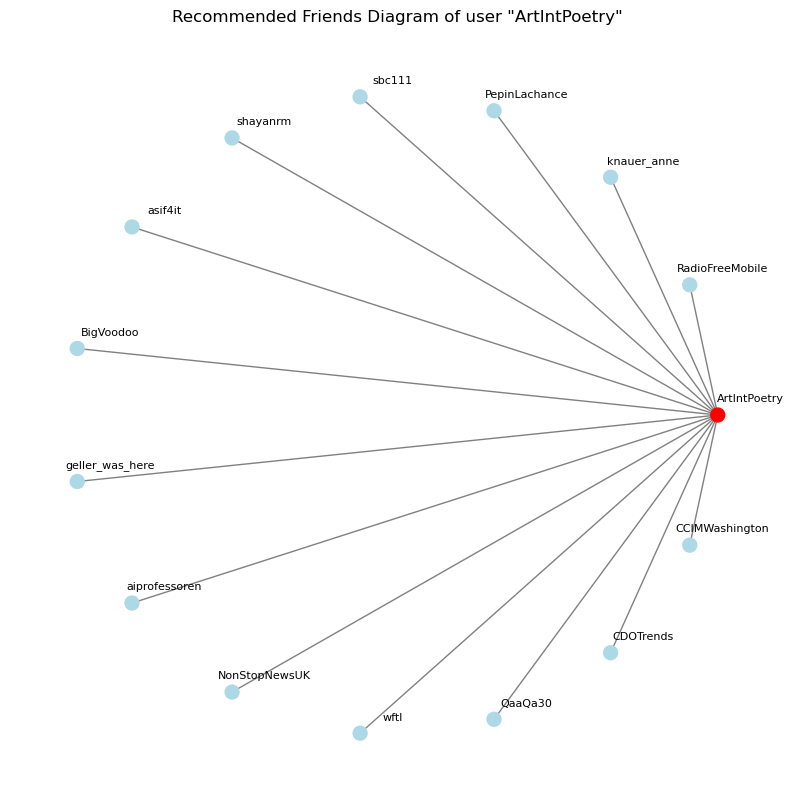

In [122]:
neighbors = [x[1] for x in recommended]
friends = nx.Graph()
for x in neighbors:
    friends.add_edge("ArtIntPoetry",x)

egonet = nx.ego_graph(friends, 'ArtIntPoetry')
pos = nx.circular_layout(egonet)
node_colors = ['lightblue' if node != 'ArtIntPoetry' else 'red' for node in egonet.nodes()]

plt.figure(figsize=(10, 10)) 

# Draw the nodes
nx.draw_networkx_nodes(egonet, pos, node_color=node_colors, node_size=100)

# Draw the edges
nx.draw_networkx_edges(egonet, pos, edge_color='gray')

# Draw the labels with adjusted positioning
label_pos = {k: (v[0] + 0.1, v[1] + 0.05) for k, v in pos.items()} 
nx.draw_networkx_labels(egonet, label_pos, font_size=8)

plt.title('Recommended Friends Diagram of user "ArtIntPoetry"')
plt.axis('off')  # Hide the axis

plt.show()

# 5. Recommend Topics

In [107]:
def recommend_topics(G, B,user,j_threshold,topic_threshold):
    
    recommended_topics = []
    v_topics = []
   
    multiply_rank = [f[2]*f[3] for f in recommend_friends(B,G,user,j_threshold,topic_threshold)]
    similar_users = [f[1] for f in recommend_friends(B,G,user,j_threshold,topic_threshold)]
    sorted_similar_users = [x for _, x in sorted(zip(multiply_rank, similar_users), reverse=True)]

    # Find the topics of the user
    user_topics = set(B[user])

    # Iterate over each neighbor
    for v in sorted_similar_users:
        # Find the topics of the neighbor
        topics = set(B.neighbors(v)) - user_topics
        for topic in topics:
            if topic not in recommended_topics:
                recommended_topics.append(topic)

    return recommended_topics

recommended_topics = recommend_topics(G, B, "ArtIntPoetry", j_threshold=0.5,topic_threshold=2)
print("Recommended Topics:")
for index, value in enumerate(recommended_topics):
    print(index+1,":",value)

In [116]:
recommended_topics = recommend_topics(G, B, "ArtIntPoetry", j_threshold=0.5,topic_threshold=2)
print("Recommended Topics:")
for index, value in enumerate(recommended_topics):
    print(index+1,":",value)

Recommended Topics:
1 : Natural Language Processing (NLP)
2 : Medical/Healthcare
3 : Music
4 : Social Media
5 : Legal
